In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)
n_samples = 500

# Создаем признаки с разными зависимостями
X1 = np.random.uniform(-10, 10, n_samples)  # Линейная зависимость
X2 = np.random.uniform(-5, 5, n_samples)    # Квадратичная зависимость
X3 = np.random.normal(0, 2, n_samples)      # Случайный шум

In [3]:
# Создаем целевую переменную с комплексной зависимостью
y = (3 * X1 +                    # Линейный компонент
     2 * X2**2 -                 # Квадратичный компонент
     0.5 * X1 * X2 +             # Взаимодействие признаков
     np.sin(X2) * 5 +            # Нелинейность (синус)
     np.random.normal(0, 5, n_samples))  # Шум

In [4]:
data = pd.DataFrame({
    'X1_linear': X1,
    'X2_quadratic': X2,
    'X3_noise': X3,
    'target': y
})

In [5]:
print("="*60)
print("СГЕНЕРИРОВАННЫЙ ДАТАСЕТ ДЛЯ РЕГРЕССИИ")
print("="*60)
print(f"Размер: {data.shape}")
print(f"\nПервые 5 строк:")
print(data.head())
print(f"\nСтатистика:")
print(data.describe().round(3))

СГЕНЕРИРОВАННЫЙ ДАТАСЕТ ДЛЯ РЕГРЕССИИ
Размер: (500, 4)

Первые 5 строк:
   X1_linear  X2_quadratic  X3_noise     target
0  -2.509198      1.981617  0.355402   8.063826
1   9.014286      0.360964 -2.670689  26.680064
2   4.639879     -1.904724  0.760396  24.411158
3   1.973170      3.137950  1.221171  27.318842
4  -6.879627      1.847312  1.119581  -6.579237

Статистика:
       X1_linear  X2_quadratic  X3_noise   target
count    500.000       500.000   500.000  500.000
mean      -0.029        -0.180     0.234   16.563
std        5.974         2.855     1.968   25.415
min       -9.899        -4.954    -5.793  -40.603
25%       -5.174        -2.709    -1.111   -1.560
50%        0.263        -0.282     0.254   15.441
75%        5.122         2.263     1.472   32.375
max        9.859         4.997     5.159  106.882


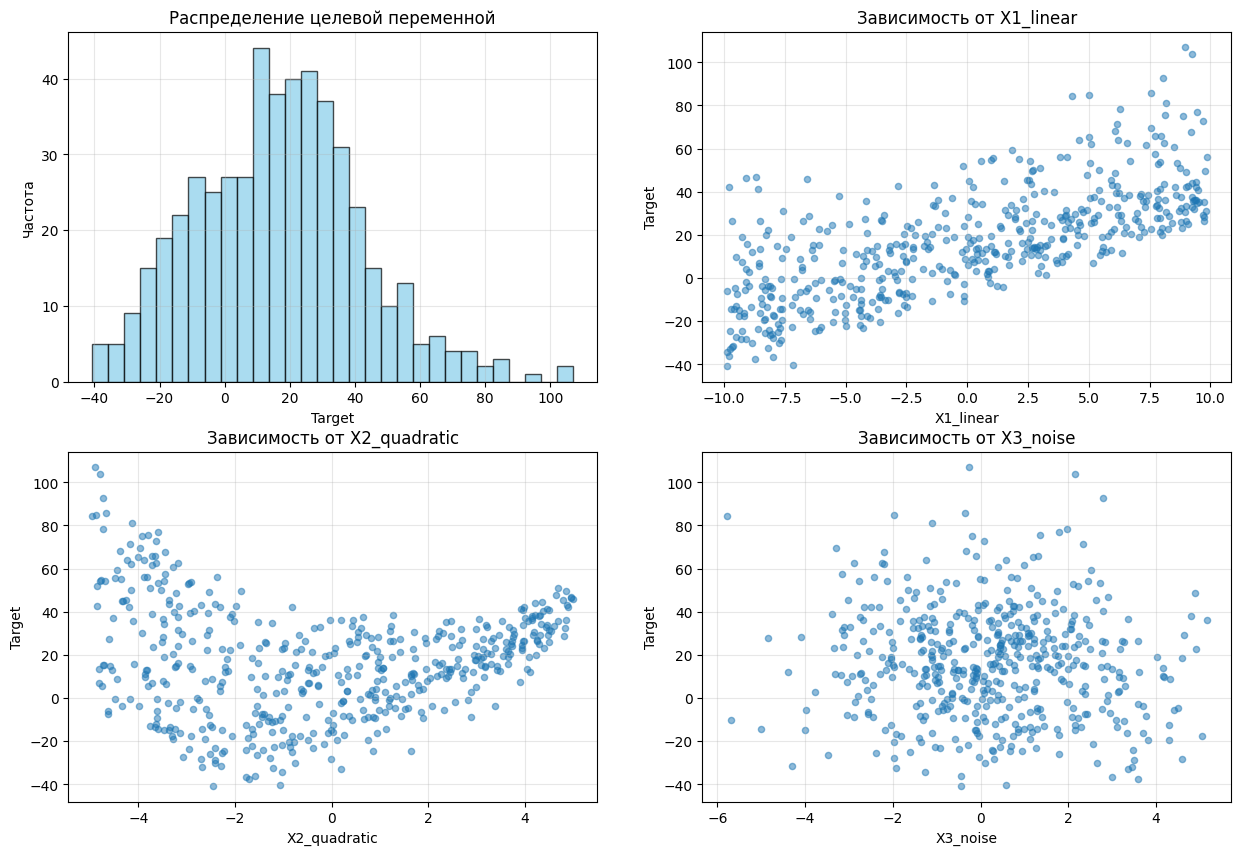

In [6]:
# ============================================================================
# АНАЛИЗ ДАННЫХ
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение целевой переменной
axes[0, 0].hist(data['target'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Target')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение целевой переменной')
axes[0, 0].grid(True, alpha=0.3)

# Зависимости от каждого признака
for i, feature in enumerate(['X1_linear', 'X2_quadratic', 'X3_noise']):
    row = (i + 1) // 2
    col = (i + 1) % 2
    axes[row, col].scatter(data[feature], data['target'], alpha=0.5, s=20)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Target')
    axes[row, col].set_title(f'Зависимость от {feature}')
    axes[row, col].grid(True, alpha=0.3)

In [9]:
corr_matrix = data.corr()
print("\nКорреляция признаков с целевой переменной:")
print(corr_matrix['target'].sort_values(ascending=False))


Корреляция признаков с целевой переменной:
target          1.000000
X1_linear       0.715033
X2_quadratic   -0.022998
X3_noise       -0.075471
Name: target, dtype: float64


In [10]:
# ============================================================================
# ПРЕДОБРАБОТКА ДАННЫХ
# ============================================================================

# Разделение на признаки и целевую переменную
X = data.drop('target', axis=1)
y = data['target']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nРазделение данных:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Разделение данных:
Train: X=(400, 3), y=(400,)
Test:  X=(100, 3), y=(100,)


In [11]:
# ============================================================================
# РЕАЛИЗАЦИЯ ВСЕХ ВИДОВ РЕГРЕССИИ
# ============================================================================

print("\n" + "="*60)
print("РЕАЛИЗАЦИЯ ВСЕХ ВИДОВ РЕГРЕССИИ")
print("="*60)

# ЛИНЕЙНАЯ РЕГРЕССИЯ
print("\n1. ЛИНЕЙНАЯ РЕГРЕССИЯ")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"   R²: {r2_lr:.4f}")
print(f"   Коэффициенты: {lr_model.coef_.round(4)}")
print(f"   Intercept: {lr_model.intercept_:.4f}")



РЕАЛИЗАЦИЯ ВСЕХ ВИДОВ РЕГРЕССИИ

1. ЛИНЕЙНАЯ РЕГРЕССИЯ
   R²: 0.4453
   Коэффициенты: [18.5907 -0.5204 -0.0324]
   Intercept: 16.8326


In [12]:
# ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ (степень 2)
print("\n2. ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ (степень 2)")
poly_degree = 2
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('linear', LinearRegression())
])
poly_model.fit(X_train_scaled, y_train)
y_pred_poly = poly_model.predict(X_test_scaled)
r2_poly = r2_score(y_test, y_pred_poly)

# Получаем полиномиальные признаки
poly_transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_scaled)
print(f"   R²: {r2_poly:.4f}")
print(f"   Степень полинома: {poly_degree}")
print(f"   Количество признаков до: {X_train_scaled.shape[1]}")
print(f"   Количество признаков после: {X_train_poly.shape[1]}")


2. ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ (степень 2)
   R²: 0.9296
   Степень полинома: 2
   Количество признаков до: 3
   Количество признаков после: 9


In [13]:
# СЛУЧАЙНЫЙ ЛЕС
print("\n3. СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"   R²: {r2_rf:.4f}")
print(f"   Количество деревьев: {rf_model.n_estimators}")
print(f"   Максимальная глубина: {rf_model.max_depth}")


3. СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)
   R²: 0.9392
   Количество деревьев: 100
   Максимальная глубина: 10


In [14]:
# ДЕРЕВО ПРИНЯТИЯ РЕШЕНИЙ
print("\n4. ДЕРЕВО ПРИНЯТИЯ РЕШЕНИЙ (DECISION TREE)")
dt_model = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"   R²: {r2_dt:.4f}")
print(f"   Глубина дерева: {dt_model.get_depth()}")
print(f"   Количество листьев: {dt_model.get_n_leaves()}")


4. ДЕРЕВО ПРИНЯТИЯ РЕШЕНИЙ (DECISION TREE)
   R²: 0.8543
   Глубина дерева: 5
   Количество листьев: 28


In [15]:
# ЭЛАСТИКНЕТ (ElasticNet)
print("\n5. ЭЛАСТИКНЕТ (ElasticNet)")
en_model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.5,  # 0 = Ridge, 1 = Lasso
    max_iter=10000,
    random_state=42
)
en_model.fit(X_train_scaled, y_train)
y_pred_en = en_model.predict(X_test_scaled)
r2_en = r2_score(y_test, y_pred_en)
print(f"   R²: {r2_en:.4f}")
print(f"   Alpha: {en_model.alpha}")
print(f"   L1 ratio: {en_model.l1_ratio} (0=Ridge, 1=Lasso)")
print(f"   Коэффициенты: {en_model.coef_.round(4)}")


5. ЭЛАСТИКНЕТ (ElasticNet)
   R²: 0.4493
   Alpha: 0.1
   L1 ratio: 0.5 (0=Ridge, 1=Lasso)
   Коэффициенты: [17.6514 -0.441  -0.0857]


In [16]:
# МЕТОД ОПОРНЫХ ВЕКТОРОВ (SVR)
print("\n6. МЕТОД ОПОРНЫХ ВЕКТОРОВ ДЛЯ РЕГРЕССИИ (SVR)")
svr_model = SVR(
    kernel='rbf',  # radial basis function
    C=10,          # параметр регуляризации
    epsilon=0.1,   # размер эпсилон-трубки
    gamma='scale'  # параметр ядра
)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"   R²: {r2_svr:.4f}")
print(f"   Ядро: {svr_model.kernel}")
print(f"   C: {svr_model.C}")
print(f"   Epsilon: {svr_model.epsilon}")


6. МЕТОД ОПОРНЫХ ВЕКТОРОВ ДЛЯ РЕГРЕССИИ (SVR)
   R²: 0.8876
   Ядро: rbf
   C: 10
   Epsilon: 0.1


In [17]:
# Создаем DataFrame с результатами
results = pd.DataFrame({
    'Модель': ['Линейная', 'Полиномиальная', 'Случайный лес',
               'Дерево решений', 'Эластикнет', 'SVR'],
    'R²': [r2_lr, r2_poly, r2_rf, r2_dt, r2_en, r2_svr],
    'MSE': [mean_squared_error(y_test, y_pred_lr),
            mean_squared_error(y_test, y_pred_poly),
            mean_squared_error(y_test, y_pred_rf),
            mean_squared_error(y_test, y_pred_dt),
            mean_squared_error(y_test, y_pred_en),
            mean_squared_error(y_test, y_pred_svr)],
    'MAE': [mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_poly),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_dt),
            mean_absolute_error(y_test, y_pred_en),
            mean_absolute_error(y_test, y_pred_svr)]
})

# Сортируем по R²
results = results.sort_values('R²', ascending=False)

print("\n" + "="*60)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ РЕГРЕССИИ")
print("="*60)
print(results.to_string(index=False))


СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ РЕГРЕССИИ
        Модель       R²        MSE       MAE
 Случайный лес 0.939218  36.174365  4.544961
Полиномиальная 0.929587  41.906193  5.148679
           SVR 0.887568  66.914219  5.655663
Дерево решений 0.854348  86.685025  7.175337
    Эластикнет 0.449314 327.740922 14.161316
      Линейная 0.445337 330.107856 14.216752


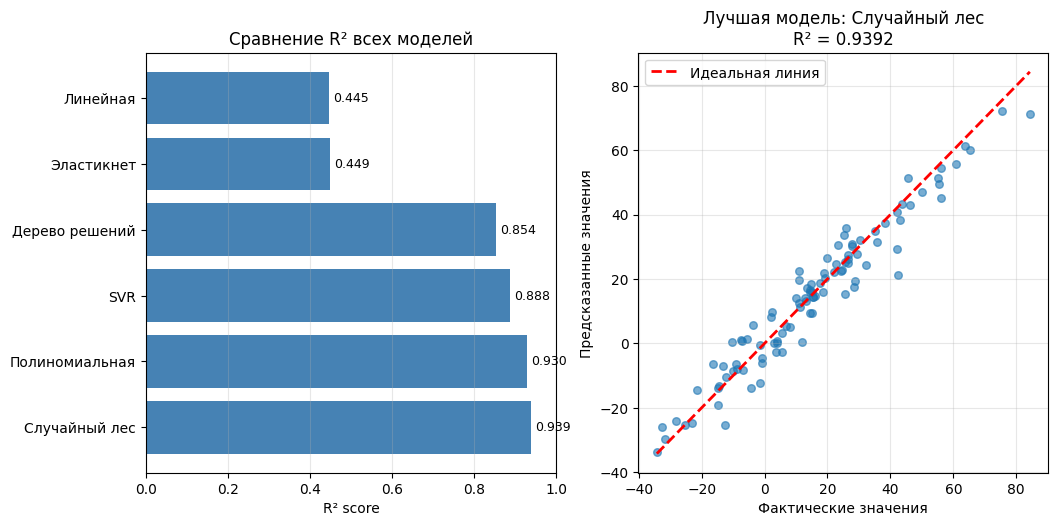

In [18]:
# ============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# ============================================================================

fig = plt.figure(figsize=(18, 12))

# 1. Сравнение R² всех моделей
ax1 = plt.subplot(2, 3, 1)
bars = ax1.barh(results['Модель'], results['R²'], color='steelblue')
ax1.set_xlabel('R² score')
ax1.set_title('Сравнение R² всех моделей')
ax1.set_xlim([0, 1])
ax1.grid(True, alpha=0.3, axis='x')

# Добавляем значения на столбцы
for bar, r2 in zip(bars, results['R²']):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{r2:.3f}', va='center', fontsize=9)

# 2. Фактические vs Предсказанные для лучшей модели
ax2 = plt.subplot(2, 3, 2)
best_model_name = results.iloc[0]['Модель']

# Выбираем предсказания лучшей модели
model_predictions = {
    'Линейная': y_pred_lr,
    'Полиномиальная': y_pred_poly,
    'Случайный лес': y_pred_rf,
    'Дерево решений': y_pred_dt,
    'Эластикнет': y_pred_en,
    'SVR': y_pred_svr
}

y_pred_best = model_predictions[best_model_name]
ax2.scatter(y_test, y_pred_best, alpha=0.6, s=30)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Идеальная линия')
ax2.set_xlabel('Фактические значения')
ax2.set_ylabel('Предсказанные значения')
ax2.set_title(f'Лучшая модель: {best_model_name}\nR² = {results.iloc[0]["R²"]:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)


6. ВИЗУАЛИЗАЦИЯ РЕГРЕССИИ НА ОДНОМ ПАРАМЕТРЕ
Выбранный параметр для визуализации: X1_linear
Корреляция с целевой переменной: 0.715
Форма X_single: (400, 1)
Форма X_test_single: (100, 1)


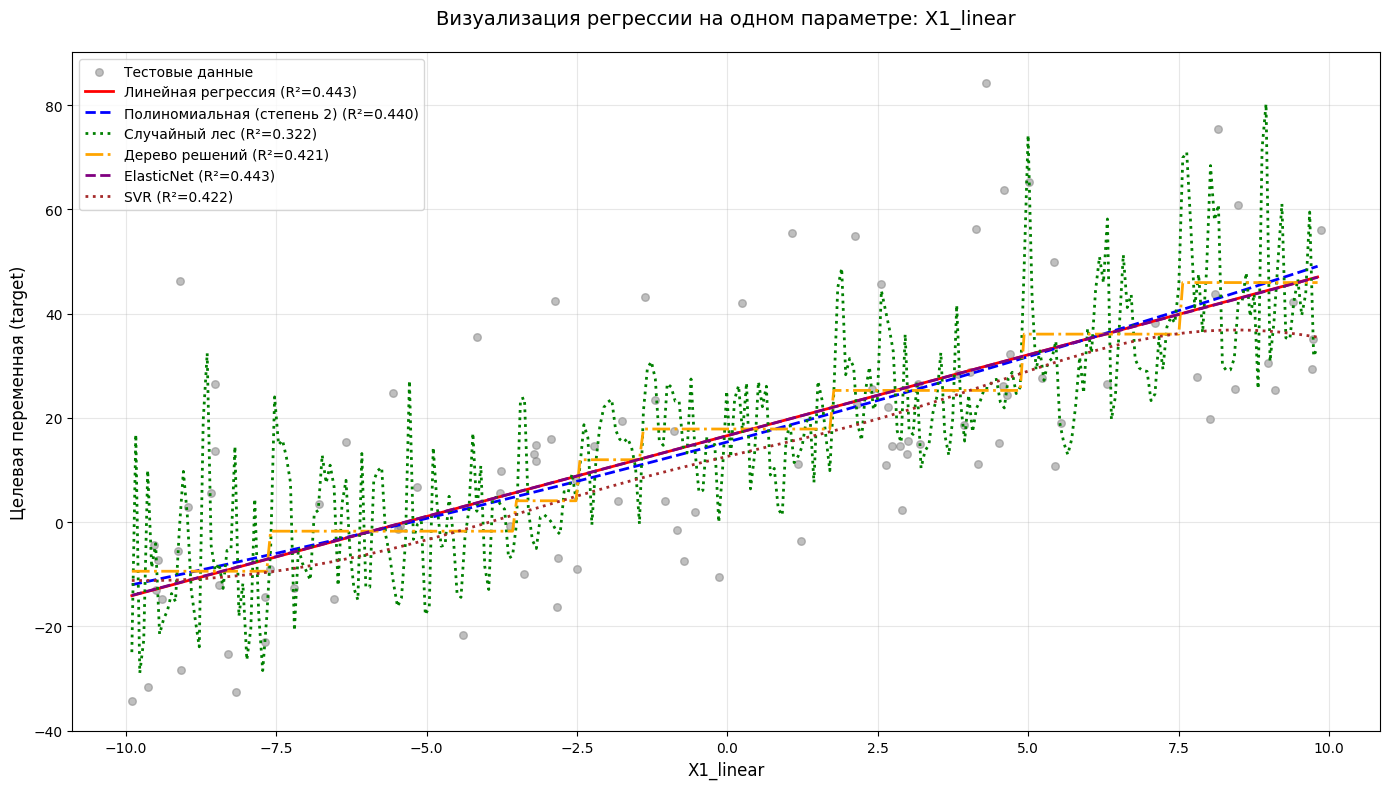


Метрики моделей на признаке 'X1_linear':
----------------------------------------------------------------------
Модель                    R²         MSE        MAE       
----------------------------------------------------------------------
Линейная регрессия        0.4426     331.75     14.24     
Полиномиальная (степень 2) 0.4399     333.37     14.30     
Случайный лес             0.3219     403.55     15.07     
Дерево решений            0.4214     344.35     14.55     
ElasticNet                0.4428     331.63     14.24     
SVR                       0.4222     343.88     14.09     
----------------------------------------------------------------------

Статистика по признаку 'X1_linear':
  Min: -9.90
  Max: 9.81
  Mean: 0.08
  Std: 5.99


In [20]:
# ============================================================================
# ВИЗУАЛИЗАЦИЯ РЕГРЕССИИ НА ОДНОМ ПАРАМЕТРЕ
# ============================================================================

print("\n" + "="*60)
print("6. ВИЗУАЛИЗАЦИЯ РЕГРЕССИИ НА ОДНОМ ПАРАМЕТРЕ")
print("="*60)

# Выбираем наиболее коррелированный признак
most_correlated_feature = data.corr()['target'].drop('target').abs().idxmax()
print(f"Выбранный параметр для визуализации: {most_correlated_feature}")
print(f"Корреляция с целевой переменной: {data.corr()['target'][most_correlated_feature]:.3f}")

# Создаем простую модель для визуализации на одном признаке
X_single = X_train[[most_correlated_feature]].values.reshape(-1, 1)
X_test_single = X_test[[most_correlated_feature]].values.reshape(-1, 1)

print(f"Форма X_single: {X_single.shape}")
print(f"Форма X_test_single: {X_test_single.shape}")

models_single = [
    ('Линейная регрессия', LinearRegression()),
    ('Полиномиальная (степень 2)', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # include_bias=False
        ('linear', LinearRegression())
    ])),
    ('Случайный лес', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('Дерево решений', DecisionTreeRegressor(max_depth=3, random_state=42)),
    ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)),
    ('SVR', SVR(kernel='rbf', C=10))
]

# Создаем сетку значений для визуализации (только по одному признаку)
X_grid = np.linspace(X_single.min(), X_single.max(), 300).reshape(-1, 1)
plt.figure(figsize=(14, 8))

# Отображаем исходные данные
plt.scatter(X_test_single, y_test, alpha=0.5, s=30, color='gray', label='Тестовые данные', zorder=1)

# Для каждой модели строим кривую регрессии
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', ':', '-.', '--', ':']
linewidths = [2, 2, 2, 2, 2, 2]

for idx, (name, model) in enumerate(models_single):
    try:
        # Обучаем модель на одном признаке
        model.fit(X_single, y_train)

        # Для полиномиальной регрессии используем тот же pipeline
        y_grid_pred = model.predict(X_grid)

        # Расчет R² для этой модели на одном признаке
        y_pred_single = model.predict(X_test_single)
        r2_single = r2_score(y_test, y_pred_single)

        # Построение кривой регрессии
        plt.plot(X_grid, y_grid_pred,
                 color=colors[idx],
                 linestyle=linestyles[idx],
                 linewidth=linewidths[idx],
                 label=f'{name} (R²={r2_single:.3f})',
                 zorder=2)

    except Exception as e:
        print(f"Ошибка при обучении модели {name}: {e}")

plt.xlabel(most_correlated_feature, fontsize=12)
plt.ylabel('Целевая переменная (target)', fontsize=12)
plt.title(f'Визуализация регрессии на одном параметре: {most_correlated_feature}', fontsize=14, pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Вывод метрик для каждой модели на одном признаке
print(f"\nМетрики моделей на признаке '{most_correlated_feature}':")
print("-" * 70)
print(f"{'Модель':<25} {'R²':<10} {'MSE':<10} {'MAE':<10}")
print("-" * 70)

for name, model in models_single:
    try:
        model.fit(X_single, y_train)
        y_pred_single = model.predict(X_test_single)

        r2 = r2_score(y_test, y_pred_single)
        mse = mean_squared_error(y_test, y_pred_single)
        mae = mean_absolute_error(y_test, y_pred_single)

        print(f"{name:<25} {r2:<10.4f} {mse:<10.2f} {mae:<10.2f}")
    except Exception as e:
        print(f"{name:<25} Ошибка: {str(e)[:30]}...")

print("-" * 70)

# Дополнительная информация
print(f"\nСтатистика по признаку '{most_correlated_feature}':")
print(f"  Min: {X_single.min():.2f}")
print(f"  Max: {X_single.max():.2f}")
print(f"  Mean: {X_single.mean():.2f}")
print(f"  Std: {X_single.std():.2f}")